In [161]:
# It enables the system to understand users’ preferences when the user/item profiles are provided. For example, if a user’s 
# playlist contains Justice League, Avengers, Aquaman, and The Shining, chances are that he/she prefers the action and horror
# genres. If using collaborative filtering, this user would be suggested some other genre for eg:comedies because other audience who watched Justice 
# League, Avengers, Aquaman, and The Shining watched comedies. This sometimes doesn’t make sense if this certain user doesn’t 
# like comedies at all. But with content filtering, such an issue can be avoided since the system has been acknowledged what the
# preference of this user is.

In [162]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Source : https://www.kaggle.com/shubhammehta21/movie-lens-small-latest-dataset
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
movies = movies.replace({np.nan: None})

movie_initial = movies

In [163]:
# Movie dataset has
# movieId – once the recommendation is done, we get a list of all similar movieId and get the title for each 
# movie from this dataset.
# genres – which is not required for this filtering approach

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [164]:
# Ratings dataset has
# userId – unique no for each user.
# movieId – using this feature, we take the title of the movie from the movies dataset.
# rating – Ratings given by each user to all the movies 
# using this we are going to predict the top 10 similar movies.

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


total of 20 unique genres from 22084 occurances.


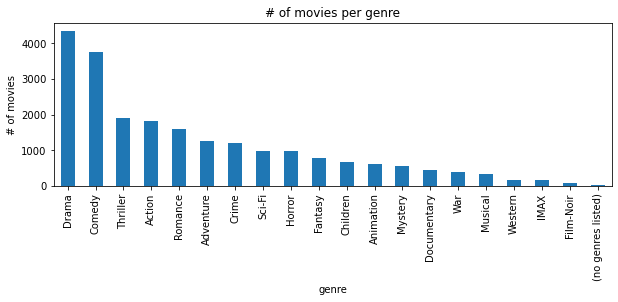

In [165]:
# All the genres are present in the genres field inside movies dataset so we first find all the genres present in the dataset
# and visualize the count for each genre

all_genres = [s.split("|") for s in movies[movies.genres.notnull()].genres]
genres = [item for l in all_genres for item in l ]
unique_genres = set(genres)
print (f"total of {len(unique_genres)} unique genres from {len(genres)} occurances.")

pd.Series(genres).value_counts().plot(kind='bar', figsize=(10, 3))
plt.title("# of movies per genre")
plt.ylabel("# of movies")
plt.xlabel("genre")
plt.show()

In [168]:
# Now we update the movies dataframe by adding all the genres as column headings
genres = [item.strip() for l in all_genres for item in l ]
unique_genres = set(genres)
for genre in unique_genres:
    movies[genre] = 0

movies.head()

,movieId,title,genres,Western,Children,Action,Animation,(no genres listed),Thriller,Horror,...,Musical,Mystery,Romance,War,Sci-Fi,Fantasy,Film-Noir,Comedy,Adventure,Drama
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
# Now we iterate over all the movies and find the genres for each movie and mark only that field as 1
# So if any field(genre) is marked 1 for any given movie it indicates that the movie belongs to that genre

for i in range(len(movies)):
    if type(movies['genres'].iloc[i]) != None.__class__:
        Genres = movies.iloc[i].genres.split('|')
        for g in Genres:
            movies[g].iloc[i] = 1

movies.head()

,movieId,title,genres,Western,Children,Action,Animation,(no genres listed),Thriller,Horror,...,Musical,Mystery,Romance,War,Sci-Fi,Fantasy,Film-Noir,Comedy,Adventure,Drama
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,1,1,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [171]:
#We now remove the title and genres column as they are no longer needed
#We then set the movieId as index and sort the dataframe based on movieId

movies = movies.drop(columns=['title', 'genres']).set_index('movieId')

movies.sort_index(axis=0, inplace=True)
movies.head()

,Western,Children,Action,Animation,(no genres listed),Thriller,Horror,Documentary,IMAX,Crime,Musical,Mystery,Romance,War,Sci-Fi,Fantasy,Film-Noir,Comedy,Adventure,Drama
movieId,,,,,,,,,,,,,,,,,,,,
1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [173]:
# We are now going to make a new dataframe where each column would represent each unique userId and each row represents each 
# unique movieId so that it is easier to visualize.
user_x_movie = pd.pivot_table(ratings, values='rating', index=['movieId'], columns = ['userId'])
user_x_movie.sort_index(axis=0, inplace=True)

#We also make all the NA values as 0 (i.e the places where user has not rated a movie)
user_x_movie.fillna(0,inplace=True)
user_x_movie

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:
#We use tqdm to visualize the iterations over each genre
from tqdm import tqdm

userIDs = user_x_movie.columns
user_profile = pd.DataFrame(columns = movies.columns)

#We calculate the Users's preference of each genre in any movie
for i in tqdm(range(len(user_x_movie.columns))):
    working_df = movies.mul(user_x_movie.iloc[:,i], axis=0)
    user_profile.loc[userIDs[i]] = working_df.mean(axis=0)

100%|███████████████████████████████████████████████████████████████████████████████| 610/610 [00:03<00:00, 203.00it/s]


In [183]:
user_profile

,Western,Children,Action,Animation,(no genres listed),Thriller,Horror,Documentary,IMAX,Crime,Musical,Mystery,Romance,War,Sci-Fi,Fantasy,Film-Noir,Comedy,Adventure,Drama
1,0.003085,0.019642,0.040004,0.013986,0.0,0.023447,0.006067,0.000000,0.000000,0.020156,0.010592,0.007713,0.011518,0.010181,0.017380,0.020773,0.000514,0.036508,0.038359,0.031674
2,0.000360,0.000000,0.004473,0.000000,0.0,0.003805,0.000309,0.001337,0.001543,0.003908,0.000000,0.000823,0.000463,0.000463,0.001594,0.000000,0.000000,0.002879,0.001285,0.006787
3,0.000000,0.000257,0.005142,0.000206,0.0,0.002982,0.003856,0.000000,0.000000,0.000103,0.000051,0.000514,0.000257,0.000257,0.006479,0.001388,0.000000,0.000926,0.003085,0.001234
4,0.003908,0.003908,0.008536,0.002468,0.0,0.013883,0.001748,0.000823,0.000309,0.010592,0.006582,0.008227,0.020156,0.002571,0.003497,0.007199,0.001645,0.037536,0.010901,0.042986
5,0.000617,0.003805,0.002879,0.002674,0.0,0.003291,0.000309,0.000000,0.001131,0.004731,0.002262,0.000411,0.003497,0.001028,0.000514,0.002982,0.000000,0.005348,0.002674,0.009770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.005965,0.017380,0.049362,0.016043,0.0,0.072141,0.017894,0.001954,0.005039,0.049979,0.016865,0.035479,0.136569,0.025350,0.028898,0.035891,0.003137,0.154360,0.052962,0.271905
607,0.000823,0.006684,0.027561,0.002057,0.0,0.025812,0.014809,0.000000,0.000514,0.010592,0.001851,0.008124,0.010490,0.002571,0.012032,0.007713,0.000000,0.018819,0.016043,0.033834
608,0.002982,0.022265,0.094868,0.017637,0.0,0.094200,0.033114,0.001851,0.004936,0.054247,0.009358,0.025195,0.031469,0.006993,0.056613,0.034245,0.001543,0.099907,0.059955,0.098982
609,0.000411,0.000617,0.003497,0.000309,0.0,0.004731,0.000720,0.000617,0.000309,0.002160,0.000000,0.000000,0.001645,0.001440,0.001543,0.000309,0.000000,0.002365,0.003291,0.006582


In [188]:
# We first calculate the document frequency (df) the number of terms(in this case genres) within all movies
df = movies.sum()

# We then calculate Inverse document frequency (IDF) which measures the importance of each term (in this case genre) 
# within all movies  
idf = (len(movies)/df).apply(np.log)

print("\nDocument Frequency : \n",df,"\n\nInverse Document Frequency : \n",idf,"\n")


Document Frequency : 
 Western                167
Children               664
Action                1828
Animation              611
(no genres listed)      34
Thriller              1894
Horror                 978
Documentary            440
IMAX                   158
Crime                 1199
Musical                334
Mystery                573
Romance               1596
War                    382
Sci-Fi                 980
Fantasy                779
Film-Noir               87
Comedy                3756
Adventure             1263
Drama                 4361
dtype: int64 

Inverse Document Frequency : 
 Western               4.066208
Children              2.685920
Action                1.673224
Animation             2.769105
(no genres listed)    5.657841
Thriller              1.637755
Horror                2.298692
Documentary           3.097427
IMAX                  4.121607
Crime                 2.094959
Musical               3.373061
Mystery               2.833316
Romance           

In [189]:
#We now calculate TF-IDF which is the weight of each term(genre) within each movie
TFIDF = movies.mul(idf.values)
TFIDF

,Western,Children,Action,Animation,(no genres listed),Thriller,Horror,Documentary,IMAX,Crime,Musical,Mystery,Romance,War,Sci-Fi,Fantasy,Film-Noir,Comedy,Adventure,Drama
movieId,,,,,,,,,,,,,,,,,,,,
1,0.0,2.68592,0.000000,2.769105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.526191,0.0,0.953092,2.042957,0.000000
2,0.0,2.68592,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.526191,0.0,0.000000,2.042957,0.000000
3,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.808946,0.0,0.0,0.000000,0.0,0.953092,0.000000,0.000000
4,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.808946,0.0,0.0,0.000000,0.0,0.953092,0.000000,0.803745
5,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.953092,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.00000,1.673224,2.769105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.526191,0.0,0.953092,0.000000,0.000000
193583,0.0,0.00000,0.000000,2.769105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.526191,0.0,0.953092,0.000000,0.000000
193585,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.803745


In [150]:
#We now calculate the sum product of the importance weights and users’ preferences towards different genres 

df_predict = pd.DataFrame()

for i in tqdm(range(len(user_x_movie.columns))):
    working_df = TFIDF.mul(user_profile.iloc[i], axis=1)
    df_predict[user_x_movie.columns[i]] = working_df.sum(axis=1) 

100%|███████████████████████████████████████████████████████████████████████████████| 610/610 [00:04<00:00, 130.28it/s]


In [190]:
df_predict

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.257124,0.005371,0.011952,0.093561,0.035717,0.167487,0.097899,0.025238,0.018216,0.094271,...,0.118148,0.048139,0.230575,0.054178,0.282867,0.437089,0.093845,0.412854,0.012268,0.628943
2,0.183600,0.002626,0.010501,0.050951,0.023216,0.109304,0.069180,0.016267,0.011686,0.052467,...,0.082283,0.032922,0.122745,0.038130,0.232658,0.245545,0.070213,0.268795,0.009160,0.405310
3,0.055630,0.003582,0.001347,0.072237,0.011422,0.089015,0.029982,0.016663,0.008925,0.073655,...,0.021549,0.028006,0.243859,0.017213,0.064979,0.394166,0.036912,0.152146,0.005231,0.232902
4,0.081088,0.009037,0.002339,0.106787,0.019274,0.130839,0.044736,0.022614,0.014877,0.092418,...,0.039486,0.046521,0.405286,0.028454,0.080188,0.612708,0.064105,0.231702,0.010521,0.386311
5,0.034795,0.002744,0.000882,0.035775,0.005097,0.041950,0.015192,0.007547,0.005391,0.025288,...,0.008527,0.012938,0.105267,0.009213,0.028424,0.147120,0.017937,0.095221,0.002254,0.150305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.192937,0.010230,0.013562,0.075077,0.024853,0.121831,0.082911,0.019231,0.013430,0.072661,...,0.085997,0.047781,0.234842,0.046659,0.201503,0.364805,0.089231,0.389305,0.009738,0.684880
193583,0.126001,0.002744,0.004959,0.060795,0.020035,0.082083,0.047034,0.012348,0.009128,0.057002,...,0.058207,0.021971,0.151215,0.026699,0.163217,0.282210,0.043116,0.230569,0.003888,0.364569
193585,0.025458,0.005455,0.000992,0.034550,0.007852,0.041824,0.014754,0.005951,0.005951,0.018763,...,0.017936,0.018515,0.161427,0.011241,0.015209,0.218542,0.027194,0.079556,0.005290,0.153409


In [191]:
#Based on the sum-product, we simply sort the movies and suggest the users the top 10 candidates as the recommendations.

def recommender(user_no):
  #user predicted rating to all films
  user_predicted_rating = df_predict[df_predict.columns[user_no - 1]]

  #combining film rating and film detail
  user_rating_film = pd.merge(user_predicted_rating, movie_initial, left_on='movieId', right_on='movieId')

  #films already watched by user
  already_watched = ratings[ratings['userId'].isin([user_no])]['movieId']

  #recommendation without films being watched by user
  all_rec = user_rating_film[~user_rating_film.index.isin(already_watched)]
  
  return all_rec.sort_values(by=[user_no], ascending=False).iloc[0:10][['movieId', 'title']]

In [198]:
#Here are some examples where we are given 10 recommendations once we enter a give userID

In [199]:
recommender(600)

,movieId,title
6626,56152,Enchanted (2007)
1390,1907,Mulan (1998)
7530,84637,Gnomeo & Juliet (2011)
3194,4306,Shrek (2001)
7805,92348,Puss in Boots (Nagagutsu o haita neko) (1969)
7170,71999,Aelita: The Queen of Mars (Aelita) (1924)
4631,6902,Interstate 60 (2002)
9169,148775,Wizards of Waverly Place: The Movie (2009)
2250,2987,Who Framed Roger Rabbit? (1988)
5819,32031,Robots (2005)


In [200]:
recommender(400)

,movieId,title
7372,79132,Inception (2010)
7441,81132,Rubber (2010)
5556,26701,Patlabor: The Movie (Kidô keisatsu patorebâ: T...
167,198,Strange Days (1995)
1978,2625,Black Mask (Hak hap) (1996)
7170,71999,Aelita: The Queen of Mars (Aelita) (1924)
2248,2985,RoboCop (1987)
454,519,RoboCop 3 (1993)
400,459,"Getaway, The (1994)"
6358,49530,Blood Diamond (2006)


In [201]:
recommender(267)

,movieId,title
7170,71999,Aelita: The Queen of Mars (Aelita) (1924)
5980,36509,"Cave, The (2005)"
9394,164226,Maximum Ride (2016)
6145,43932,Pulse (2006)
5161,8361,"Day After Tomorrow, The (2004)"
9707,187031,Jurassic World: Fallen Kingdom (2018)
7767,91500,The Hunger Games (2012)
6330,48774,Children of Men (2006)
8590,117529,Jurassic World (2015)
5665,27618,"Sound of Thunder, A (2005)"
